In [107]:
import pandas as pd
import os
import seaborn as sns
import numpy as np

In [135]:
aal = pd.read_excel('../data/raw/asset_damage/Saint Lucia/AAL Results 19022016 StLucia FinalSummary2.xlsx', sheet_name='AAL St. Lucia Province', header=1)
aal.set_index('Name', inplace=True)
aal = aal[['AAL as % of Total AAL']]
aal = aal[aal.index.notnull()]
# pml = aal.multiply(total_pml[self.return_period])
# df = pd.merge(df, pml, left_on='District', right_index=True)
# df.to_excel(
#     f'../data/processed/asset_damage/{self.country}/{self.country}.xlsx', index=False)

In [136]:
aal

,AAL as % of Total AAL
Name,
AnseLaRayeCanaries,0.017227
Dennery,0.044604
Gros Islet,0.182812
Laborie,0.034031
Choiseul,0.018592
Micoud,0.079705
Soufriere,0.02808
Vieuxfort,0.071302
Canaries,0.004226


In [134]:
# Drop all rows where index is 
aal.dropna(axis=0, subset=index)

NameError: name 'index' is not defined

In [124]:
aal['AAL as % of Total AAL']

0    0.017227
1    0.044604
2    0.182812
3    0.034031
4    0.018592
5    0.079705
6    0.028080
7    0.071302
8    0.004226
9    0.519422
Name: AAL as % of Total AAL, dtype: float64

## Specify parameters

First we need to specify the paths to the experiment results. The structure of `experiments` folder is as folows. First goes the `country` name, then `state` or `district` name, then the name of the `policy` and finally `scenario`.

In [56]:
country = 'Saint Lucia'
districts = next(os.walk(f'../experiments/{country}'))[1]
policies = next(os.walk(f'../experiments/{country}/{districts[0]}'))[1]
scenarios = next(os.walk(f'../experiments/{country}/{districts[0]}/{policies[0]}'))[1]

print(f'Country: {country}')
print(f'Districts: {districts}')
print(f'Policies: {policies}')
print(f'Scenarios: {scenarios}')

Country: Saint Lucia
Districts: ['Saint Lucia']
Policies: ['None', 'PDS']
Scenarios: ['100']


## Load data

Now we can load the files of interest.

In [48]:
def _load_experiments():
    pass

In [10]:
# Files of interest:
# * households
# * affected_households
# * impoverished_households
# * households_weeks_in_poverty
# * household_consumption_loss

In [11]:
# TODO: Rename `households_data` into `households`?
# TODO: Rename `affected_hh_data_...` into `affected_households`?

In [ ]:
# To be loaded:
# * households
# * affected_households
# * impoverished_households
# * households_weeks_in_poverty
# * household_consumption_loss

In [90]:
# ?: Aggregate over the replications?

# Outcomes structure: district -> policy -> scenario -> outcome -> data -> replication -> value
outcomes = {}
for district in districts:
    outcomes[district] = {}
    for policy in policies:
        outcomes[district][policy] = {}
        for scenario in scenarios:
            outcomes[district][policy][scenario] = {}
            path = f'../experiments/{country}/{district}/{policy}/{scenario}/'
            households = pd.read_csv(path + 'household_data.csv')
            affected_households = pd.read_csv(path + 'hh_is_affected.csv', index_col=0)
            impoverished_households = pd.read_csv(path + 'hh_is_impoverished.csv', index_col=0)
            households_weeks_in_poverty = pd.read_csv(path + 'hh_weeks_pov.csv', index_col=0)
            household_consumption_loss = pd.read_csv(path + 'hh_consumption_loss.csv', index_col=0)
            # * drm costs - Disaster Risk Management costs
            # drm_costs = pd.read_csv(path + 'hh_DRM_cost.csv', index_col=0)
            outcomes[district][policy][scenario]['households'] = households
            outcomes[district][policy][scenario]['affected_households'] = affected_households
            outcomes[district][policy][scenario]['impoverished_households'] = impoverished_households
            outcomes[district][policy][scenario]['households_weeks_in_poverty'] = households_weeks_in_poverty
            outcomes[district][policy][scenario]['household_consumption_loss'] = household_consumption_loss
            # outcomes[district][policy][scenario]['drm_costs'] = drm_costs


In [91]:
# Consumption loss and poverty impacts

In [95]:
d = {}
for policy in policies:
    data = pd.DataFrame()
    for district in districts:
        households = outcomes[district][policy][scenario]['households']
        household_consumption_loss = outcomes[district]['PDS'][scenario]['household_consumption_loss']
        df = pd.DataFrame()
        df['mean_household_consumption_loss'] = household_consumption_loss.mean(axis=1)
        df['popwgt'] = households['popwgt']
        df['aeexp'] = households['aeexp']
        df['mean_consumption_loss'] = (df['mean_household_consumption_loss'] / df['popwgt']) * 100
        df['is_poor'] = households['is_poor']
        df['district'] = district
    data = pd.concat([data, df])
    data.sort_index(inplace=True)
    d[policy] = df

In [ ]:
# ?: Should I do rescaling here? I think we already did that in `_adjust_asset_and_expenditure()`

In [119]:
# ?: What's that?
print(round(df.loc[df['mean_household_consumption_loss'] > 50, 'popwgt'].sum() / df['popwgt'].sum(), 5))
print(round(df.loc[df['mean_household_consumption_loss'] < 20, 'popwgt'].sum() / df['popwgt'].sum(), 5))

0.15731
0.83704


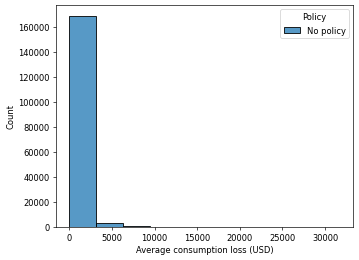

In [118]:
column = 'mean_household_consumption_loss'
ax = sns.histplot(data=df, x=column, weights='popwgt', bins=10, label='No policy');
ax.set_xlabel('Average consumption loss (USD)')
ax.legend(title='Policy');

## Do analysis